Github link:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import email
import pandas as pd

**Preprocessing**

In [2]:

from email.message import EmailMessage
def get_email_body(msg: EmailMessage) -> str:
    """
    This function extracts the body of an email message.

    Args:
        msg: EmailMessage: The email message to extract the body from.
    
    Returns:
        str: The body of the email message.
    """
    if msg.is_multipart():
        # Iterate over each part of a multipart message
        for part in msg.walk():
           
            if part.get_content_type() in ("text/plain", "text/html"):
                return part.get_payload()
    else:
        # For non-multipart messages, simply return the payload
        return msg.get_payload()
    

def load_data():
    """
    This function loads the needed data and stores in the global variables training_set and test_set.

    Folders 0-70 are the training data and 71-100 are the test data.

    Args:
        None

    Returns:
        None

    """
    # determining the spam and ham directories
    labels = []
    spam_directory_list = []
    ham_directory_list = []
    with open("labels", "r") as f:
        text = f.read()
        labels = text.split("\n")

    for directory in labels:
        if "ham" in directory:
            ham_directory_list.append(directory[7:])  # 7 is the index where the base directory starts ex. data/000/001
        else:
            spam_directory_list.append(directory[8:]) # 8 is the index where the base directory starts ex. data/000/001

    test_set  = []
    ham_training_set = []
    spam_training_set = []
    folders = os.listdir("data")
    del folders[0] # removes the .DS_Store file

    for folder in folders:
        # gets all files in the folder
        files = os.listdir("data/"+folder)

        # iterates over and reads all files in the folder    
        for file in files:
            directory = "data/"+folder+"/"+file
            with open(f"data/{folder}/{file}", mode="r", encoding="utf-8", errors='ignore') as f:
                data = f.read()

                msg = email.message_from_string(data)
                charset = msg.get_content_charset()

                if charset is None or "x-utf-2":
                    charset = "utf-8"



                with open(f"data/{folder}/{file}", mode="r", encoding=charset, errors='ignore') as f:
                    data = f.read()
                    msg = email.message_from_string(data)
                # distributes the emails to corresponding lists
                    if directory in spam_directory_list and int(folder) <= 70:
                        spam_training_set.append(get_email_body(msg))
                    elif directory in ham_directory_list and int(folder) <= 70:
                        ham_training_set.append(get_email_body(msg))
                    else:
                        test_set.append(get_email_body(msg))
    

    return ham_training_set, spam_training_set, test_set

ham_training_set, spam_training_set, test_set = load_data()

In [3]:

# removing html tags
def remove_html_tags(text: str) -> str:
    """
    This function removes html tags from the text.

    Args:
        text: string

    Returns:
        string: text without html tags    
    
    """
    inside_tag = False
    clean_text = []
    
    try:
        for char in text:
            if char == '<':
                inside_tag = True
            elif char == '>':
                inside_tag = False
            elif not inside_tag:
                clean_text.append(char)
    except:
        print(text)
    return ''.join(clean_text)


In [4]:
# removing punctuation
def remove_punctuation_and_nums(text: str) -> str:
    """
    This function removes punctuation and numbers from the text.

    Args:
        text: string
    
    Returns:
        string: text without punctuation and numbers
    
    
    """

    punctuation = '''!()-+|[]{};:'"\,<>.=/?@#$%^&*_~1234567890'''

    for mark in punctuation:
        
        text = text.replace(mark, " ")

    return ' '.join(text.split())

In [5]:
def remove_not_printable(text: str) -> str:
    """
    This function removes not printable characters from the text.

    Args:
        text: string
    
    Returns:
        string: text without not printable characters
    
    """


    for letter in text:
        if not letter.isprintable():
            text = text.replace(letter, "")
    return text

In [6]:
# removing stop words

def remove_stop_words(stop_words: list[str], text: str) -> str:
    """
    This function removes stop words from the text.
    
    Args:
        stop_words: list of stop words
        text: string
    
    Returns:
        string: text without stop words
    
    """

    return ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])


In [7]:
def cleanup_emails(data: list[str], is_remove_stop_words: bool = True) -> list[str]:
    """
    This function cleans up the emails by removing html tags, punctuation, numbers, not printable characters and stop words.

    Args:
        data: list of emails
        is_remove_stop_words: boolean

    Returns:
        list[str]: cleaned up emails
    
    """


    data = [remove_html_tags(email) for email in data]
    data = [remove_punctuation_and_nums(email) for email in data]
    data = [remove_not_printable(email) for email in data]
    if is_remove_stop_words:
        with open("stop_words.txt", mode="r") as f:
            stop_words = f.read().split() 
            data = [remove_stop_words(stop_words, email) for email in data]
    
    return data


ham_training_set = cleanup_emails(ham_training_set)
spam_training_set = cleanup_emails(spam_training_set)


In [8]:
def get_top_n_words(ham_training_set: list[str], spam_training_set: list[str], top_n: int = 1000) -> dict:
    """
    This function processes the emails and returns the top N most frequent words in the emails.

    Args:
        ham_training_set: list of ham emails
        spam_training_set: list of spam emails
        top_n: int
    
    Returns:
        dict: dictionary of the top N most frequent words in the emails
    
    
    """

    cleaned_emails = " ".join(ham_training_set + spam_training_set)
    word_count = {}
    for word in cleaned_emails.split():
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    # Sort the dictionary by value
    word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))
    # Keep only the top N words
    word_count = dict(list(word_count.items())[:top_n])

    return word_count

total_matrix_words = get_top_n_words(ham_training_set, spam_training_set)

## **Creating the feature matrices**

In [9]:

def create_matrix( words:list[str], emails: list[str]) -> pd.DataFrame:
    """
    This function creates a matrix of the words in the emails, with the words as columns and the emails as rows.
    
    The matrix contains the occurrences of the words in the emails.
    
    Args:
        words: list of words
        emails: list of emails
    
    Returns:
        pd.DataFrame: matrix of the words in the emails
    
    """

    matrix_dict = {}

    for word in words:
        matrix_dict[word] = [1 if email.count(word) > 0 else 0 for email in emails]


    return pd.DataFrame.from_dict(matrix_dict)

ham_matrix = create_matrix(list(total_matrix_words.keys()), ham_training_set)
spam_matrix = create_matrix(list(total_matrix_words.keys()), spam_training_set)


## **Computing the Priors**

In [10]:
"""Probability of spam and ham classes"""
spam_prob = len(spam_training_set) / (len(spam_training_set) + len(ham_training_set))
ham_prob = len(ham_training_set) / (len(spam_training_set) + len(ham_training_set))

## **Computing the likelihood of each word**

In [11]:

spam_word_count = np.sum(spam_matrix.values)
ham_word_count = np.sum(ham_matrix.values)

spam_word_occurrence_vector = spam_matrix.sum(axis="index")
ham_word_occurrence_vector = ham_matrix.sum(axis="index")

def word_likelihood(total_matrix_words: int, word_occurrence_vector: pd.Series, lambda_var: float = 1) -> pd.Series:
    """
    This function calculates the likelihood of a word given the class.

    Args:
        total_matrix_words: int
        word_occurrence_vector: dict
        lambda_var: float
    
    Returns:
        pd.Series: likelihood of a word given the class

    """

    
    V = len(word_occurrence_vector)
    numerator = word_occurrence_vector + lambda_var
    denominator = total_matrix_words +  (lambda_var * np.abs(V))
    return numerator / denominator


    

spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector)
ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector)



## **Classifying the emails**

In [12]:

def classify_email(spam_word_likelihood_vector: pd.Series, ham_word_likelihood_vector: pd.Series , spam_probability: float, ham_probability: float, email_word_occurrences: pd.DataFrame) -> list[int]:
    """
    This function classifies a matrix of email word occurrences as spam or ham

    Args:
        spam_word_likelihood_vector: pd.Series
        ham_word_likelihood_vector: pd.Series
        spam_probability: float
        ham_probability: float
        email_word_occurrences: pd.DataFrame
    
    Returns:
        list[int]: list of 1s and 0s, where 1 is spam and 0 is ham
    
    
    """

    spam_ham_list = []

    for i in range(len(email_word_occurrences)):
        spam_prob =  np.log(spam_word_likelihood_vector).multiply(email_word_occurrences.iloc[i]).sum(axis=0) + np.log(spam_probability)
        ham_prob = np.log(ham_word_likelihood_vector).multiply(email_word_occurrences.iloc[i]).sum(axis=0) + np.log(ham_probability)

        if spam_prob > ham_prob:
            spam_ham_list.append(1)
        else:
            spam_ham_list.append(0)
    
    return spam_ham_list

classification_list= classify_email(spam_word_likelihood_vector, ham_word_likelihood_vector, spam_prob, ham_prob, ham_matrix)


ham_count = classification_list.count(0)
spam_count = classification_list.count(1)

ham_ratio = ham_count / len(classification_list)
spam_ratio = spam_count / len(classification_list)

print(ham_count)
print(spam_count)

print(ham_ratio)
print(spam_ratio)


    



7260
263
0.9650405423368337
0.03495945766316629


## **Testing the classifier**

In [13]:
actual = []

with open("labels", "r") as f:
    text = f.read()
    actual = text.split("\n")


del actual[37822]  # remove the last empty string
actual = actual[21300:] # get the test data
actual = [1 if "spam" in directory else 0 for directory in actual]


In [14]:
for i in range(len(test_set)):
    if test_set[i] == None:
        test_set[i] = ""

In [15]:
test_set = cleanup_emails(test_set)
test_matrix = create_matrix(list(total_matrix_words.keys()), test_set)
predicted = classify_email(spam_word_likelihood_vector, ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)

        


In [16]:
def calculate_metrics(actual: list[int], predicted: list[int]) -> tuple[float, float, float]:
    """
    This function calculates the accuracy, precision and recall of the model.

    Args:
        actual: list of actual values
        predicted: list of predicted values
    
    Returns:
        tuple[float, float, float]: accuracy, precision and recall of the model
    
    """

    
    TN = 0
    TP = 0
    FP = 0
    FN = 0

    for actual, predicted in zip(actual, predicted):

        if actual  == 0 and predicted == 0:
            TN += 1
        elif actual == 1 and predicted == 1:
            TP += 1
        elif actual == 0 and predicted == 1:
            FP += 1
        else:
            FN += 1
    

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    return accuracy, precision, recall



## **Performance Evaluation**

In [17]:
print(actual)
print(predicted)
accuracy, precision, recall = calculate_metrics(actual, predicted)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 

## **RESULTS AND DISCUSSION**

**1. What  is  the  effect  of  removing  stop  words  in  terms  of  precision,  recall,  and 
accuracy?  Show a plot or a table of these results.**

Removing the stop words increased the performance of the model in all three metrics. From 0.92, removing stop words improved accuracy to 0.94. Similarly, Precision was improved from 0.93 to 0.95. Lastly, recall was improved from 0.91 to 0.93.

In [18]:
no_stop_ham_training_set, no_stop_spam_training_set, no_stop_test_set = load_data()

no_stop_ham_training_set = cleanup_emails(no_stop_ham_training_set, False)
no_stop_spam_training_set = cleanup_emails(no_stop_spam_training_set, False)

no_stop_word_count = get_top_n_words(no_stop_ham_training_set, no_stop_spam_training_set)
no_stop_ham_matrix = create_matrix(list(no_stop_word_count.keys()), no_stop_ham_training_set)
no_stop_spam_matrix = create_matrix(list(no_stop_word_count.keys()), no_stop_spam_training_set)

no_stop_spam_word_count = np.sum(no_stop_spam_matrix.values)
no_stop_ham_word_count = np.sum(no_stop_ham_matrix.values)

no_stop_spam_word_occurrence_vector = no_stop_spam_matrix.sum(axis="index")
no_stop_ham_word_occurrence_vector = no_stop_ham_matrix.sum(axis="index")


no_stop_spam_word_likelihood_vector = word_likelihood(no_stop_spam_word_count, no_stop_spam_word_occurrence_vector)
no_stop_ham_word_likelihood_vector = word_likelihood(no_stop_ham_word_count, no_stop_ham_word_occurrence_vector)

In [19]:
no_stop_test_set = cleanup_emails(no_stop_test_set, False)
no_stop_test_matrix = create_matrix(list(no_stop_word_count.keys()), no_stop_test_set)
no_stop_predicted = classify_email(no_stop_spam_word_likelihood_vector, no_stop_ham_word_likelihood_vector, spam_prob, ham_prob, no_stop_test_matrix)

no_stop_TN = 0
no_stop_TP = 0
no_stop_FP = 0
no_stop_FN = 0




None
None
None
None
None


In [20]:
no_stop_accuracy, no_stop_precision, no_stop_recall = calculate_metrics(actual, no_stop_predicted)

print(f"Stop Words Not Removed Accuracy: {no_stop_accuracy}")
print(f"Stop Words Not Removed Recall: {no_stop_recall}")
print(f"Stop Words Not Remove Precision: {no_stop_precision}")

Stop Words Not Removed Accuracy: 0.9047330831618449
Stop Words Not Removed Recall: 0.9185451279748541
Stop Words Not Remove Precision: 0.9387792565396971


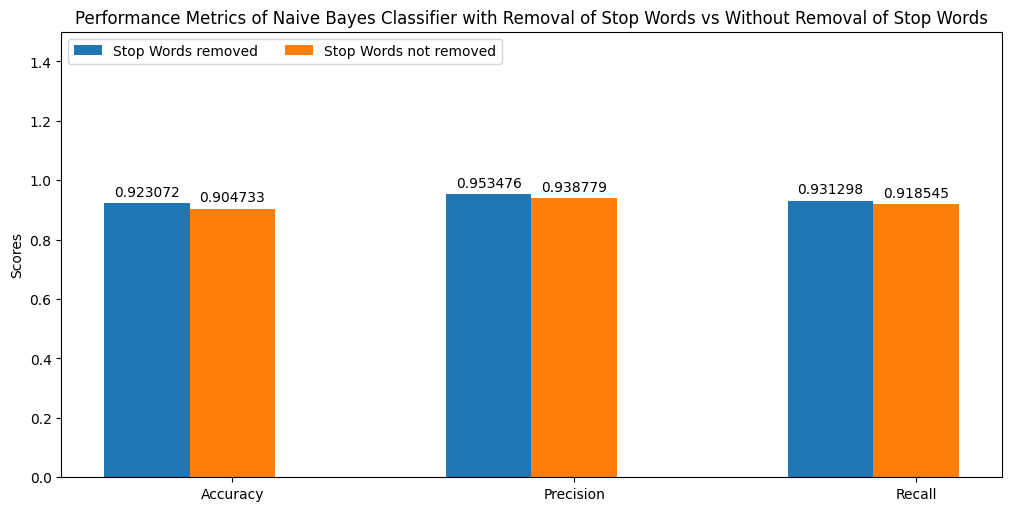

In [21]:
def plot_metrics(metrics: dict[str, list[float]], title:str, figsize: tuple[int, int] = (10, 5), width: float = 0.25) -> None:
    """
    This function plots the metrics of the model.

    Args:
        metrics: dictionary of the metrics
        title: string
        xticks: list of strings
    
    Returns:
        None
    
    """

    length = len(list(metrics.values())[0])
    x = np.arange(length)
    multiplier=0
    fig, ax = plt.subplots(layout="constrained", figsize=figsize)

    for attribute, measurement in metrics.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, alpha=1, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    xticks = ["Accuracy", "Precision", "Recall"]
    ax.set_ylabel("Scores")
    ax.set_title(title)
    ax.set_xticks(x + width, xticks)
    ax.legend(loc="upper left", ncols=3)
    ax.set_ylim(0, 1.5)
    plt.show()




# performance_metrics = {
#     "Accuracy": [accuracy, no_stop_accuracy],
#     "Precision": [precision, no_stop_precision],
#     "Recall": [recall, no_stop_recall]
# }
performance_metrics = {
    "Stop Words removed": [accuracy, precision, recall],
    "Stop Words not removed": [no_stop_accuracy, no_stop_precision, no_stop_recall]
}

plot_metrics(performance_metrics, "Performance Metrics of Naive Bayes Classifier with Removal of Stop Words vs Without Removal of Stop Words")


**2. Experiment  on  the  number  of  words  used  for  training.    Filter  the  dictionary  to 
include only words occurring more than k times (1000 words, then k > 100, and k 
= 50 times).  For example, the word “offer” appears 150 times, that means that it 
will be included in the dictionary.**

Based from the chart below, the filtering strategy of using only words that occur more than 100 times has high precision at 0.94, and has lower accuracy and recall (0.86, 0.84) as compared to filtering the top 10000 words (0.89, 0.93). Meanwhile, filtering words that only occur 50 times has a really high recall at at 0.98 but performs worse in terms of accuracy and precision (0.70, 0.70).

In [22]:
from typing import Callable
def get_words_with_different_filters(spam_set: list[str], ham_set: list[str], filtering_strategy: Callable, n: int) -> dict:

    """
    This function returns the words that occur more than n times in the emails.

    Args:
        spam_set: list of spam emails
        ham_set: list of ham emails
        n: int
    
    Returns:
        dict: dictionary of words that occur more than n times in the emails
    
    """

    cleaned_emails = " ".join(spam_set + ham_set)
    word_count = {}
    for word in cleaned_emails.split():
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    # word_count = {k: v for k, v in word_count.items() if v > n}
    word_count = filtering_strategy(word_count, n)

    return word_count


In [23]:
def gt_occurrence_strategy(word_count: dict, n: int) -> dict:
    return {k: v for k, v in word_count.items() if v > n}

def equal_occurrence_strategy(word_count: dict, n: int) -> dict:
    return {k: v for k, v in word_count.items() if v == n}

In [24]:
ham_set_n_occurrences, spam_set_n_occurrences, test_set_gt_occurrences = load_data()
test_set_equal_occurrences = test_set_gt_occurrences[:]

word_count_gt_occurrences = get_words_with_different_filters(ham_set_n_occurrences, spam_set_n_occurrences, gt_occurrence_strategy, 100)
word_count_equal_occurrences = get_words_with_different_filters(ham_set_n_occurrences, spam_set_n_occurrences, equal_occurrence_strategy, 50)

In [25]:
"""solving for word likelihoods with words that occur more than 100 times"""

ham_matrix_gt_occurrences = create_matrix(list(word_count_gt_occurrences.keys()), ham_training_set)
spam_matrix_gt_occurrences = create_matrix(list(word_count_gt_occurrences.keys()), spam_training_set)

spam_word_count_gt_occurrences = np.sum(spam_matrix_gt_occurrences.values)
ham_word_count_gt_occurrences = np.sum(ham_matrix_gt_occurrences.values)

spam_word_occurrence_vector_gt_occurrences = spam_matrix_gt_occurrences.sum(axis="index")
ham_word_occurrence_vector_gt_occurrences = ham_matrix_gt_occurrences.sum(axis="index")


ham_word_likelihood_vector_gt_occurrences = word_likelihood(ham_word_count_gt_occurrences, ham_word_occurrence_vector_gt_occurrences)
spam_word_likelihood_vector_gt_occurrences = word_likelihood(spam_word_count_gt_occurrences, spam_word_occurrence_vector_gt_occurrences)


"""solving for word likelihoods with words that occur exactly 50 times"""
ham_matrix_equal_occurrences = create_matrix(list(word_count_equal_occurrences.keys()), ham_training_set)
spam_matrix_equal_occurrences = create_matrix(list(word_count_equal_occurrences.keys()), spam_training_set)

spam_word_count_equal_occurrences = np.sum(spam_matrix_equal_occurrences.values)
ham_word_count_equal_occurrences = np.sum(ham_matrix_equal_occurrences.values)

spam_word_occurrence_vector_equal_occurrences = spam_matrix_equal_occurrences.sum(axis="index")
ham_word_occurrence_vector_equal_occurrences = ham_matrix_equal_occurrences.sum(axis="index")

ham_word_likelihood_vector_equal_occurrences = word_likelihood(ham_word_count_equal_occurrences, ham_word_occurrence_vector_equal_occurrences)
spam_word_likelihood_vector_equal_occurrences = word_likelihood(spam_word_count_equal_occurrences, spam_word_occurrence_vector_equal_occurrences)

In [26]:
test_set_gt_occurrences = cleanup_emails(test_set_gt_occurrences)
test_matrix_gt_occurrences = create_matrix(list(word_count_gt_occurrences.keys()), test_set_gt_occurrences)
predicted_gt_occurrences = classify_email(spam_word_likelihood_vector_gt_occurrences, ham_word_likelihood_vector_gt_occurrences, spam_prob, ham_prob, test_matrix_gt_occurrences)

test_set_equal_occurrences = cleanup_emails(test_set_equal_occurrences)
test_matrix_equal_occurrences = create_matrix(list(word_count_equal_occurrences.keys()), test_set_equal_occurrences)
predicted_equal_occurrences = classify_email(spam_word_likelihood_vector_equal_occurrences, ham_word_likelihood_vector_equal_occurrences, spam_prob, ham_prob, test_matrix_equal_occurrences)

accuracy_gt_occurrences, precision_gt_occurrences, recall_gt_occurrences = calculate_metrics(actual, predicted_gt_occurrences)
accuracy_equal_occurrences, precision_equal_occurrences, recall_equal_occurrences = calculate_metrics(actual, predicted_equal_occurrences)

None
None
None
None
None
None
None
None
None
None


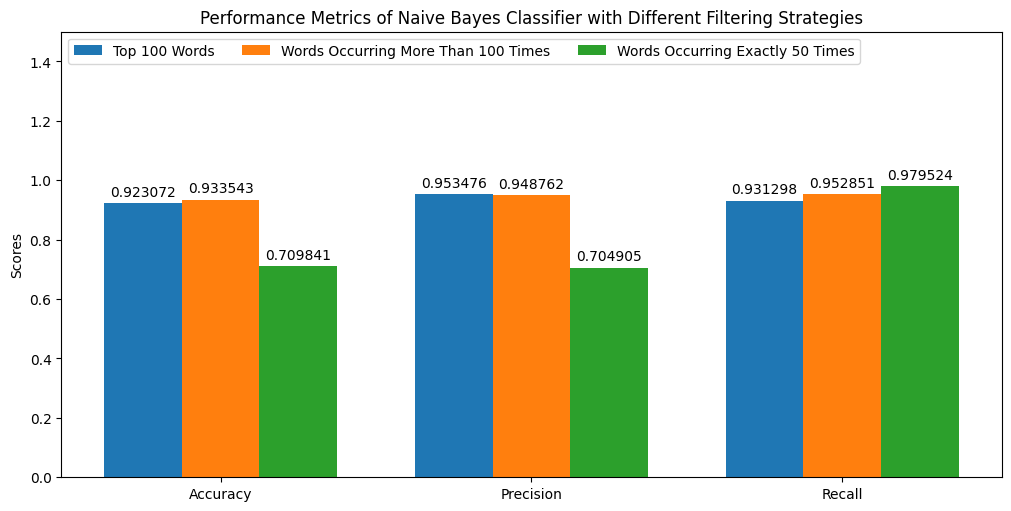

In [27]:
word_performance_metrics = {
    "Top 100 Words": [accuracy, precision, recall],
    "Words Occurring More Than 100 Times": [accuracy_gt_occurrences, precision_gt_occurrences, recall_gt_occurrences],
    "Words Occurring Exactly 50 Times": [accuracy_equal_occurrences, precision_equal_occurrences, recall_equal_occurrences]
}

plot_metrics(word_performance_metrics, "Performance Metrics of Naive Bayes Classifier with Different Filtering Strategies")

**3. Discuss the results of the different parameters used for Lambda smoothing.  Test 
it  on  5  varying  values  of  the  λ  (e.g.  λ  =  2.0,  1.0,  0.5,  0.1,  0.005),    Evaluate 
performance metrics for each.**

Using different lambda values do not change the performance metrics by a lot, especially if the lambda values do not have a great difference. However, a really high lambda value changes the performance metric by a lot.

In [28]:
lambda_2_ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector, 2)
lambda_2_spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector, 2)

lambda_05_ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector, 0.5)
lambda_05_spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector, 0.5)

lambda_01_ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector, 0.1)
lambda_01_spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector, 0.1)

lambda_005_ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector, 0.05)
lambda_005_spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector, 0.05)

lambda_10000_ham_word_likelihood_vector = word_likelihood(ham_word_count, ham_word_occurrence_vector, 10000)
lambda_10000_spam_word_likelihood_vector = word_likelihood(spam_word_count, spam_word_occurrence_vector, 10000)


predicted_lambda_2 = classify_email(lambda_2_spam_word_likelihood_vector, lambda_2_ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)
predicted_lambda_05 = classify_email(lambda_05_spam_word_likelihood_vector, lambda_05_ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)
predicted_lambda_01 = classify_email(lambda_01_spam_word_likelihood_vector, lambda_01_ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)
predicted_lambda_005 = classify_email(lambda_005_spam_word_likelihood_vector, lambda_005_ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)
predicted_lambda_10000 = classify_email(lambda_10000_spam_word_likelihood_vector, lambda_10000_ham_word_likelihood_vector, spam_prob, ham_prob, test_matrix)



accuracy_lambda_2, precision_lambda_2, recall_lambda_2 = calculate_metrics(actual, predicted_lambda_2)
accuracy_lambda_05, precision_lambda_05, recall_lambda_05 = calculate_metrics(actual, predicted_lambda_05)
accuracy_lambda_01, precision_lambda_01, recall_lambda_01 = calculate_metrics(actual, predicted_lambda_01)
accuracy_lambda_005, precision_lambda_005, recall_lambda_005 = calculate_metrics(actual, predicted_lambda_005)
accuracy_lambda_10000, precision_lambda_10000, recall_lambda_10000 = calculate_metrics(actual, predicted_lambda_10000)

lambda_performance_metrics = {
    "Lambda = 1": [accuracy, precision, recall],
    "Lambda = 2": [accuracy_lambda_2, precision_lambda_2, recall_lambda_2],
    "Lambda = 0.5": [accuracy_lambda_05, precision_lambda_05, recall_lambda_05],
    "Lambda = 0.1": [accuracy_lambda_01, precision_lambda_01, recall_lambda_01],
    "Lambda = 0.05": [accuracy_lambda_005, precision_lambda_005, recall_lambda_005],
    "Lambda = 10000": [accuracy_lambda_10000, precision_lambda_10000, recall_lambda_10000]

}


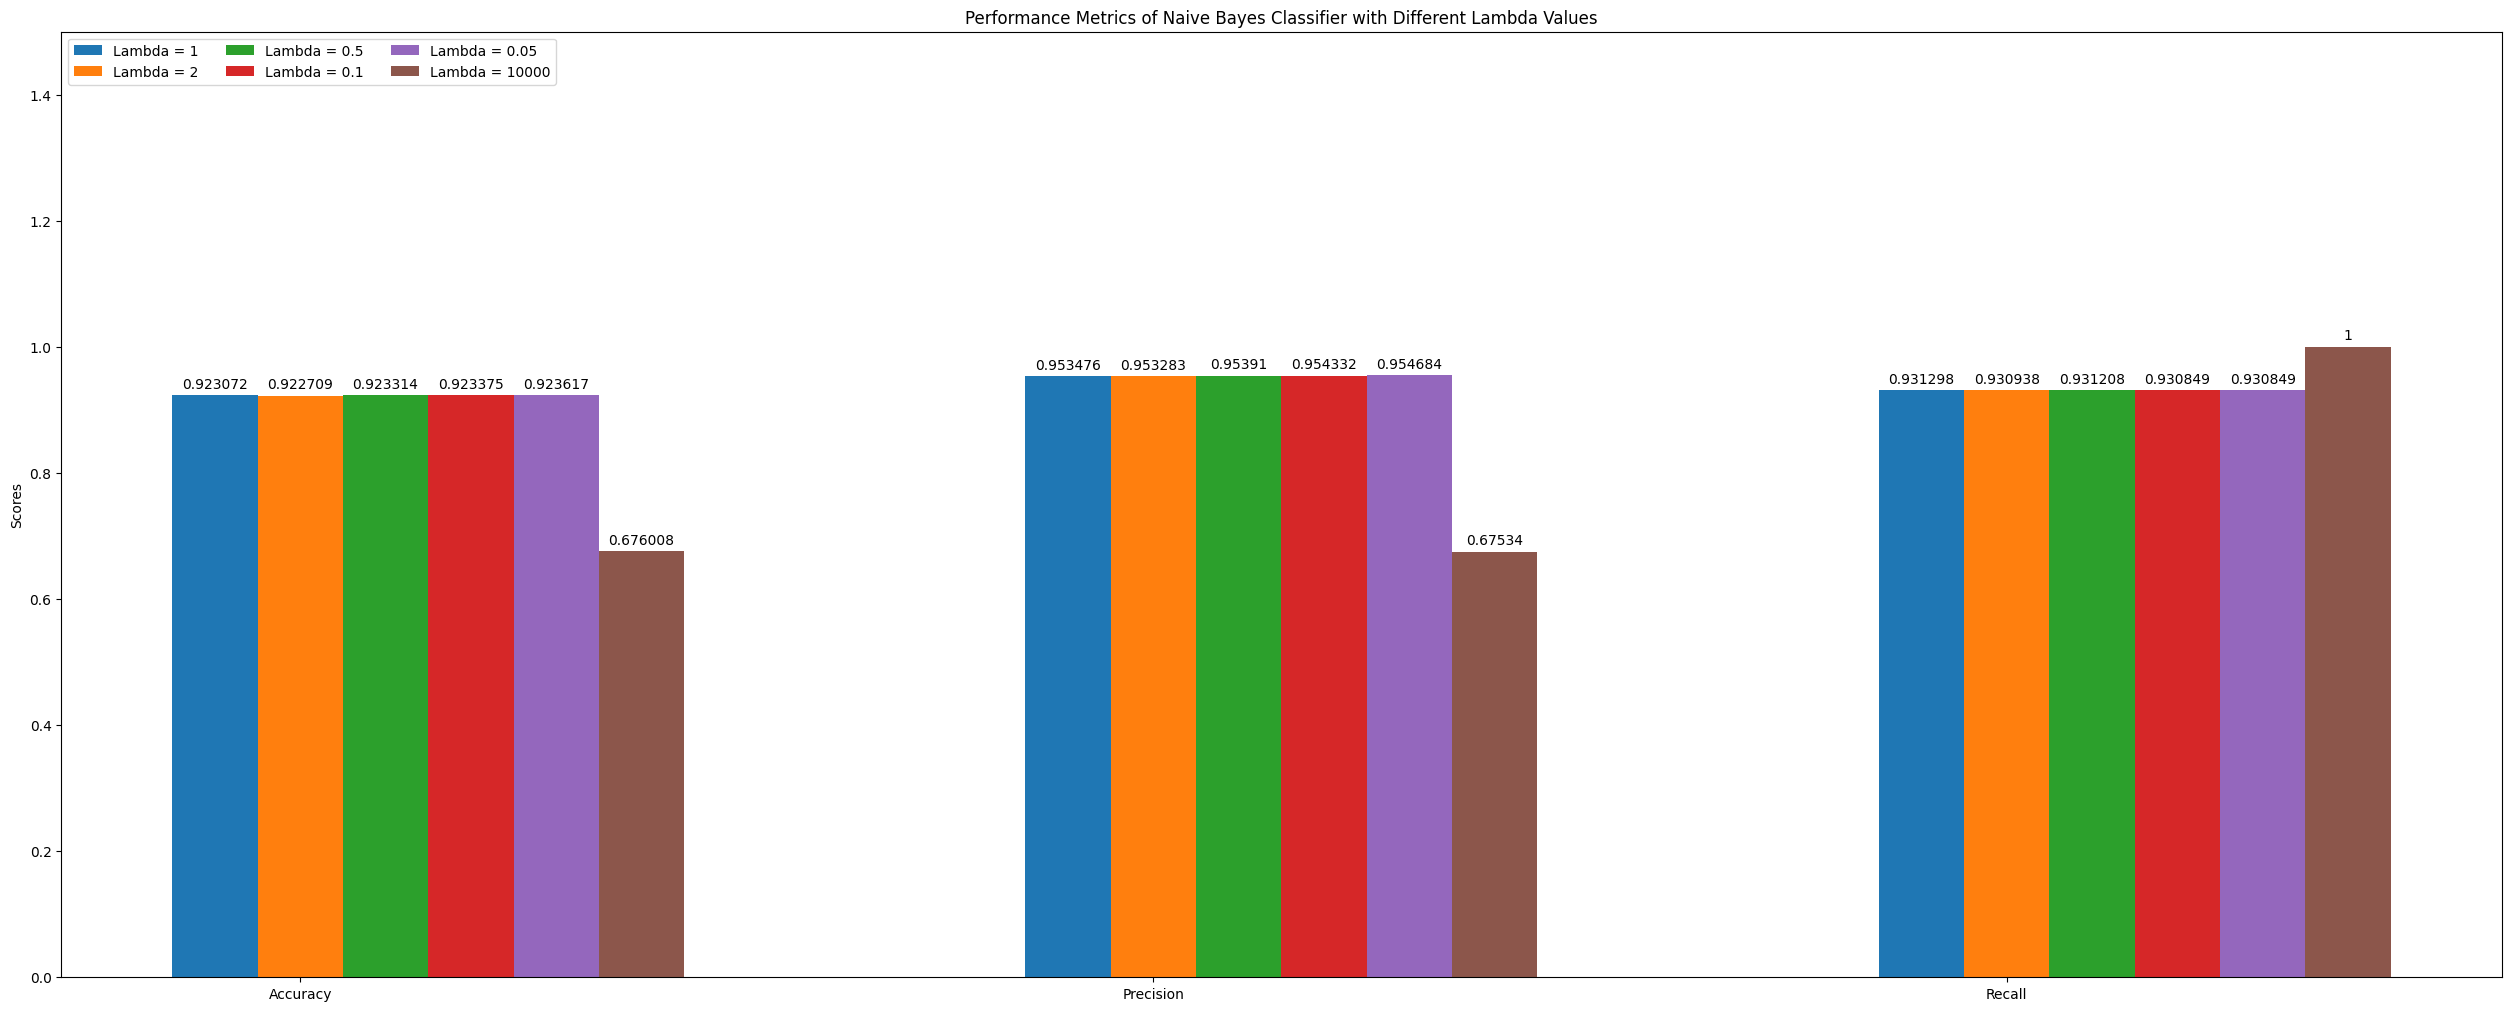

In [29]:

plot_metrics(lambda_performance_metrics, "Performance Metrics of Naive Bayes Classifier with Different Lambda Values", (25, 10), 0.1)

**4. What are your recommendations to further improve the model?**

Currently the model uses one hot encoding - using 1 to indicate the presence of the word in an email and 0 otherwise. The model could be improved by instead counting how many occurrences of the word exist in the email rather than just indicating its existence. 